In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import Matern

In [2]:
#compute Kernel and set as prior covariance (compute kernel for grid and then add 1 row and 1 column with 0s and a 1 for sigma2)

#try understanding why the covariance is same on diag

#show that you can get smooth results with 100+ data points

#try with a single-dim timeseries

In [12]:
def eta(Theta):
    """
    Theta = (theta_1, theta_2, ..., theta_d, sigma2)
    """
    return np.append(Theta[:-1]/Theta[-1], -1 / (2 * Theta[-1]) )

def eta_inv(Eta):
    return np.append( - Eta[:-1] / (2 * Eta[-1]), -1 / (2 * Eta[-1]) )

def eta_inv_jac(Eta):
    n = Eta.size

    return np.block( [
        [ np.diag(np.repeat( -1 / (2 * Eta[-1]), n-1 )), (Eta[:-1] / (2 * Eta[-1]**2)).reshape(-1, 1) ],
        [ np.zeros((1, n-1)),                           np.array([[ 1 / (2 * Eta[-1]**2) ]]) ]
               ]
            )

def eta_jac(Theta):
    n = Theta.size
    return np.block( [
        [ np.diag(np.repeat( 1 / (Theta[-1]), n-1 )), ( - Theta[:-1] / Theta[-1]**2 ).reshape(-1, 1) ],
        [ np.zeros((1, n-1)),                           np.array([[ 1 / (2 * Theta[-1]**2) ]]) ]
               ]
            )

In [13]:
test_eta = np.array([0.1, 0.4, 0.2, 0.9])
print(eta_inv(eta(test_eta)))

eta_inv_jac(test_eta)

eta_jac(eta(test_eta))

[0.1 0.4 0.2 0.9]


array([[-1.8 ,  0.  ,  0.  , -0.36],
       [ 0.  , -1.8 ,  0.  , -1.44],
       [ 0.  ,  0.  , -1.8 , -0.72],
       [ 0.  ,  0.  ,  0.  ,  1.62]])

In [5]:
class MVNormal():
    def __init__(self, eta_prior_mean, eta_prior_cov):
        self.eta_prior_mean = eta_prior_mean #prior on eta
        self.eta_prior_cov = eta_prior_cov #prior on cov of eta
        self.num_params = eta_prior_mean.size

        self.r_ = lambda X : np.append(X, np.dot(X, X))
        self.db_ = lambda X : np.zeros_like(X).reshape(-1,1)
        self.dr_ = lambda X : np.block([[np.eye(X.size)],
                                         [2 * X]])
        self.ddr_ = lambda X : np.append(np.zeros_like(X), 2 * X.size)
        return
    
    def posterior(self, data):

        Lambda = np.zeros((self.num_params, self.num_params), dtype=float)
        Nu = np.zeros(self.eta_prior_mean.shape)

        T = data.shape[-1]

        for X in data:
            Lambda += (1/T) * self.dr_(X) @ self.dr_(X).T
            Nu += (2/T) * self.ddr_(X)

        eta_post_cov = np.linalg.inv(np.linalg.inv(self.eta_prior_cov) + 2 * T * Lambda)
        eta_post_mean = eta_post_cov @ (np.linalg.inv(self.eta_prior_cov) @ self.eta_prior_mean - T * Nu)

        return eta_post_mean, eta_post_cov

sigma2 :  0.476216029252595 0.301181421768739
true sigma2 :  0.25


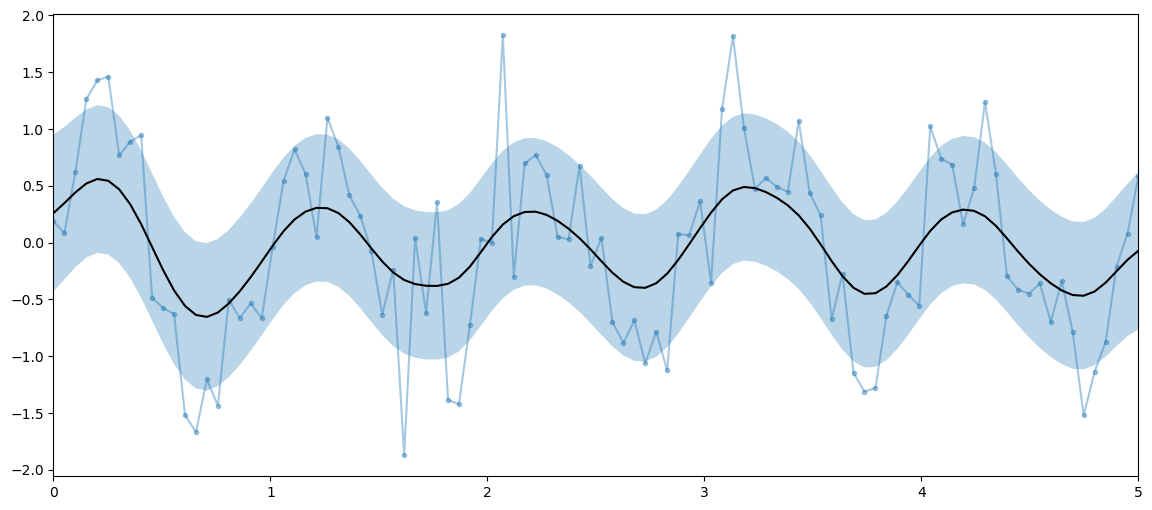

In [70]:
#Setting up the data
xmin = 0 
xmax = 5
num_data_pts = 100
grid = np.linspace(xmin, xmax, num_data_pts)

d = 1 #number of timeseries used to fit the GP
num_params = num_data_pts + 1 #a mean estimated for each time/data point, and sigma2

true_sigma2 = 0.5**2
f = lambda x : np.sin(2 * np.pi * x)
data = f(grid) + np.random.normal(loc=0, scale=np.sqrt(true_sigma2), size=(d, len(grid)))

#Setting up the prior covariance (GP kernel) and the prior mean on theta = (theta1, ..., thetaT, sigma2)
length_scale= 0.2
nu = 5/2
magnitude = 0.1
large_number = 10**8
kernel = magnitude * Matern(length_scale=length_scale, nu=nu)

sigma2 = 1.
theta_prior_mean = np.append(np.zeros((num_data_pts,)), sigma2)
theta_prior_cov = kernel(np.append(grid, large_number).reshape(-1,1)) #large number is to append 0s for cov(theta_i, sigma2)

#converting the prior on theta to natural parameters
eta_prior_mean = eta(theta_prior_mean)
eta_prior_cov = eta_jac(theta_prior_mean) @ theta_prior_cov @ eta_jac(theta_prior_mean).T

#instantiating the LogNormal class and obtaining the posterior mean and covariance for the r.v. \eta | data 
norm = MVNormal(eta_prior_mean=eta_prior_mean, eta_prior_cov=eta_prior_cov)
eta_post_mean, eta_post_cov = norm.posterior(data=data)

#converting back from eta to mu, sigma2, and obtaining the mean and covariance for mu and sigma2
theta_post_mean = eta_inv(eta_post_mean)
theta_post_cov = eta_inv_jac(eta_post_mean) @ eta_post_cov @ eta_inv_jac(eta_post_mean).T

err_estimate = 2 * np.sqrt(np.sqrt(np.diag(theta_post_cov)[:-1]))
sigma2_err_estimate = 2 * np.sqrt(np.sqrt(theta_post_cov[-1,-1]))

#plotting results
plt.figure(figsize=(14,6))
plt.plot(grid, data.T, '.-', alpha=0.4)
plt.plot(grid, theta_post_mean[:-1], color='black')
plt.fill_between(grid, theta_post_mean[:-1] - err_estimate, theta_post_mean[:-1] + err_estimate, alpha=0.3)
plt.xlim(xmin, xmax)

print("sigma2 : ", theta_post_mean[-1], sigma2_err_estimate)
print("true sigma2 : ", true_sigma2)